In [1]:
import os
import numpy as np
from bitstring import Bits
import matplotlib.pyplot as plt

# ADC conversion parameters

In [2]:
BIT_RESOLUTION = 8 # 8bit
bit_range = [-1 * 2**(BIT_RESOLUTION - 1), 2**(BIT_RESOLUTION - 1) - 1]

# Ideal conversion gain
# CONVERSION_GAIN = 0.5/256

# w/ gain calibration
CONVERSION_GAIN = (0.5 - 0.0635)/256
OFFSET = 0.00025

# In this case, the measurement input is given by Vcm + Vin & Vcm - Vin
# Thus the LSB should be considered as twice than the conversion gain
LSB = CONVERSION_GAIN * 2

INPUT_RANGE_CUT = [66, 66]

In [3]:
DATAPATH = "data"
data = []

with open(os.path.join(DATAPATH, "ideal_INL.csv")) as f:
    data = f.readlines()

# Conversion curve

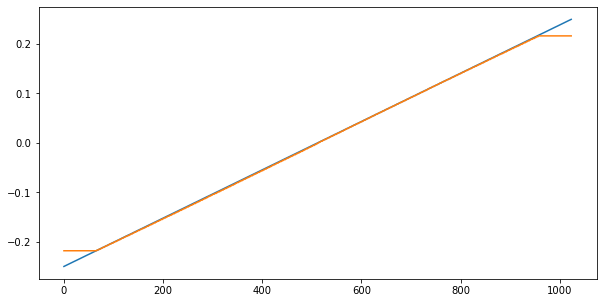

Input peak-2-peak range:  0.87


In [4]:
processed_data = np.zeros(shape=(len(data) - 1, 2))

for i in range(1, len(data)):
    temp = data[i].split(",0b")
    processed_data[i - 1, 0] = float(temp[0])
    processed_data[i - 1, 1] = Bits(bin=temp[1]).int

#print(processed_data)
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(processed_data[:,0])
plt.plot(CONVERSION_GAIN * processed_data[:,1])
plt.show()

min_input = processed_data[INPUT_RANGE_CUT[0],0]
max_input = processed_data[-1 *  INPUT_RANGE_CUT[1],0]

print("Input peak-2-peak range: {:5.2f}".format(2* (max_input - min_input)))

# INL

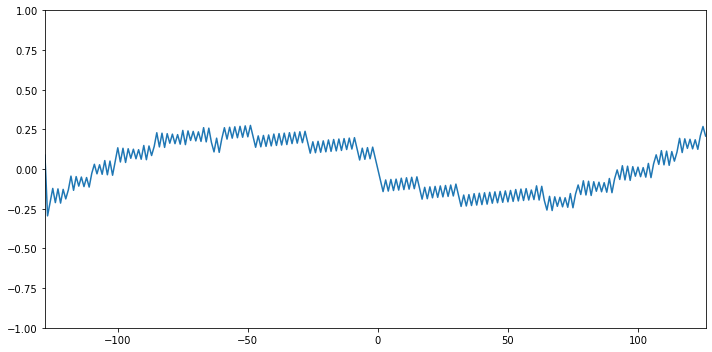

MAX INL:  0.2753
MIN INL: -0.2947


In [5]:
integrated_nonlinearity = []
for i in range(bit_range[0], bit_range[1]):
    for row in processed_data[INPUT_RANGE_CUT[0]:-INPUT_RANGE_CUT[1]]:
        if row[1] == i:
            integrated_nonlinearity.append((row[0] - OFFSET - i * CONVERSION_GAIN)/LSB)
            break

fig = plt.figure()
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.ylim(-1,1)
plt.plot(
    range(bit_range[0], bit_range[1]),
    integrated_nonlinearity)
plt.tight_layout()
plt.show()

print("MAX INL: {:7.4f}".format(max(integrated_nonlinearity[1:-1])))
print("MIN INL: {:7.4f}".format(min(integrated_nonlinearity[1:-1])))

# DNL

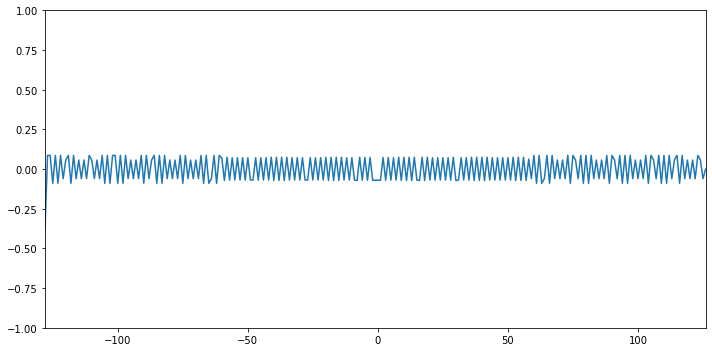

MAX DNL:  0.0865
MIN DNL: -0.0895


In [6]:
differential_nonlinearity = np.zeros_like(integrated_nonlinearity)
for i in range(len(integrated_nonlinearity) - 1):
    differential_nonlinearity[i] = integrated_nonlinearity[i + 1] - integrated_nonlinearity[i]

fig = plt.figure()
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.ylim(-1,1)
plt.plot(
    range(bit_range[0], bit_range[1]),
    differential_nonlinearity)
plt.tight_layout()
plt.show()

print("MAX DNL: {:7.4f}".format(max(differential_nonlinearity[1:-1])))
print("MIN DNL: {:7.4f}".format(min(differential_nonlinearity[1:-1])))